### Библиотеки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import logging
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate

In [2]:
logging.basicConfig(filename='anomaly_detection.log', level=logging.INFO, format='%(asctime)s - %(message)s')

In [3]:
train_data = pd.read_csv('../client/public/Dataset.csv')

In [4]:
test_data = pd.read_csv('../client/public/Test_Dataset.csv')

In [5]:
train_data.head()

,Время,Адрес источника,Порт источника,Адрес назначения,Порт назначения,Протокол,Состояние соединения,Отправленные байты,Принятые байты,Класс
0,2024-01-01 00:00:00,102.179.92.14,9436,178.174.254.238,44433,ICMP,S0,1722,2514,Аномальный
1,2024-01-01 01:00:00,106.71.188.20,37767,3.134.108.162,8220,ICMP,S0,5317,9031,Аномальный
2,2024-01-01 02:00:00,102.121.210.214,163,47.254.72.71,23465,ICMP,SF,3846,2802,Нормальный
3,2024-01-01 03:00:00,74.202.87.116,34743,115.172.80.80,51138,UDP,S0,4211,6982,Аномальный
4,2024-01-01 04:00:00,99.103.151.130,19676,112.224.95.71,30233,ICMP,SF,65,8222,Нормальный


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Время                 1000 non-null   object
 1   Адрес источника       1000 non-null   object
 2   Порт источника        1000 non-null   int64 
 3   Адрес назначения      1000 non-null   object
 4   Порт назначения       1000 non-null   int64 
 5   Протокол              1000 non-null   object
 6   Состояние соединения  1000 non-null   object
 7   Отправленные байты    1000 non-null   int64 
 8   Принятые байты        1000 non-null   int64 
 9   Класс                 1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [7]:
train_data.describe()

,Порт источника,Порт назначения,Отправленные байты,Принятые байты
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,30848.013000,31549.531000,4959.614000,4939.235000
std,19323.590433,18753.411424,2905.051654,2891.176164
min,98.000000,61.000000,3.000000,38.000000
25%,13514.000000,15606.000000,2585.500000,2515.500000
50%,29499.000000,31636.500000,4824.500000,4811.000000
75%,48221.000000,47710.750000,7437.250000,7395.500000
max,65429.000000,65498.000000,9999.000000,9997.000000


In [8]:
train_data.describe(include='object')

,Время,Адрес источника,Адрес назначения,Протокол,Состояние соединения,Класс
count,1000,1000,1000,1000,1000,1000
unique,1000,1000,1000,3,3,2
top,2024-01-01 00:00:00,102.179.92.14,178.174.254.238,UDP,S0,Аномальный
freq,1,1,1,346,354,500


In [9]:
train_data.shape

(1000, 10)

In [10]:
train_data.isnull().sum()

Время                   0
Адрес источника         0
Порт источника          0
Адрес назначения        0
Порт назначения         0
Протокол                0
Состояние соединения    0
Отправленные байты      0
Принятые байты          0
Класс                   0
dtype: int64

In [11]:
total = train_data.shape[0]
missing_columns = [col for col in train_data.columns if train_data[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train_data[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

In [12]:
print(f"Количество повторяющихся строк: {train_data.duplicated().sum()}")

Количество повторяющихся строк: 0


<Axes: xlabel='Класс', ylabel='count'>

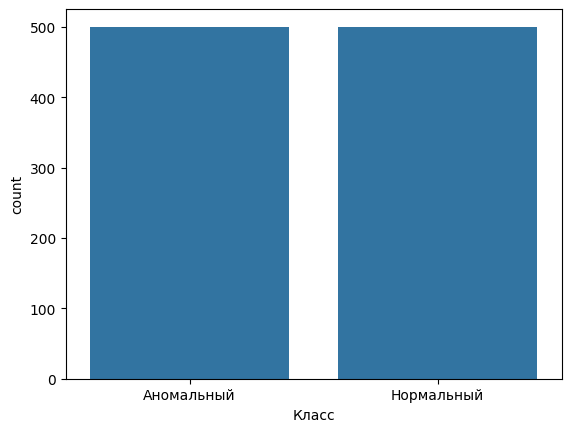

In [13]:
sns.countplot(x=train_data['Класс'])

In [14]:
print('Распределение классов. Обучающий набор:')
print(train_data['Класс'].value_counts())

Распределение классов. Обучающий набор:
Класс
Аномальный    500
Нормальный    500
Name: count, dtype: int64


In [15]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

le(train_data)
le(test_data)

In [16]:
train_data.drop(['Состояние соединения'], axis=1, inplace=True)
test_data.drop(['Состояние соединения'], axis=1, inplace=True)

In [17]:
train_data.head()

,Время,Адрес источника,Порт источника,Адрес назначения,Порт назначения,Протокол,Отправленные байты,Принятые байты,Класс
0,0,16,9436,338,44433,0,1722,2514,0
1,1,30,37767,720,8220,0,5317,9031,0
2,2,15,163,779,23465,0,3846,2802,1
3,3,901,34743,61,51138,2,4211,6982,0
4,4,999,19676,49,30233,0,65,8222,1


In [18]:
X_train = train_data.drop(['Класс'], axis=1)
Y_train = train_data['Класс']

In [19]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['Время',
 'Адрес источника',
 'Порт источника',
 'Адрес назначения',
 'Порт назначения',
 'Протокол',
 'Отправленные байты',
 'Принятые байты']

In [20]:
X_train = X_train[selected_features]

In [21]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test_data = scale.fit_transform(test_data)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

In [23]:
x_train.shape

(700, 8)

In [24]:
x_test.shape

(300, 8)

In [25]:
y_train.shape

(700,)

In [26]:
y_test.shape

(300,)

In [27]:
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [28]:
y_pred = rfc.predict(x_test)

In [29]:
for i in range(len(y_test)):
    if y_pred[i] == 1:
        logging.info(f"Аномальное поведение обнаружено в индексе {i}: {x_test[i]}")

In [30]:
rfc_score = rfc.score(x_test, y_test)
print(f"Точность случайного леса: {rfc_score}")

Точность случайного леса: 0.5433333333333333


## Logistic Regression

In [31]:
import time

In [32]:
from sklearn.linear_model import LogisticRegression

clfl = LogisticRegression(max_iter = 1200000)
start_time = time.time()
clfl.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Время обучения: ", end_time-start_time)

Время обучения:  0.002001523971557617


In [33]:
start_time = time.time()
y_test_pred = clfl.predict(x_train)
end_time = time.time()
print("Время тестирования: ", end_time-start_time)

Время тестирования:  0.0010001659393310547


In [34]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [35]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Оценка обучения: {lg_train}")
print(f"Оценка теста: {lg_test}")

Оценка обучения: 0.5428571428571428
Оценка теста: 0.5166666666666667


In [36]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [37]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Users\frenzy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## KNN

In [38]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [39]:
study_KNN = optuna.create_study(direction="maximize")
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=1, values=[0.5766666666666667], datetime_start=datetime.datetime(2024, 6, 6, 21, 22, 59, 843890), datetime_complete=datetime.datetime(2024, 6, 6, 21, 22, 59, 860906), params={'KNN_n_neighbors': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [40]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Оценка обучения: {KNN_train}")
print(f"Оценка теста: {KNN_test}")

Оценка обучения: 0.5814285714285714
Оценка теста: 0.5766666666666667


## Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

clfd = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Время обучения: ", end_time-start_time)

Время обучения:  0.004003763198852539


In [42]:
start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Время тестирования: ", end_time-start_time)

Время тестирования:  0.0


In [43]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [44]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=21, state=1, values=[0.5833333333333334], datetime_start=datetime.datetime(2024, 6, 6, 21, 23, 0, 91949), datetime_complete=datetime.datetime(2024, 6, 6, 21, 23, 0, 102960), params={'dt_max_depth': 11, 'dt_max_features': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=21, value=None)


In [45]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Оценка обучения: {dt_train}")
print(f"Оценка теста: {dt_test}")

Оценка обучения: 0.8371428571428572
Оценка теста: 0.5733333333333334


In [46]:
data = [["KNN", KNN_train, KNN_test], 
        ["LogisticRegression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test]]

col_names = ["Модель", "Оценка обучения", "Оценка теста"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════╤═══════════════════╤════════════════╕
│ Модель             │   Оценка обучения │   Оценка теста │
╞════════════════════╪═══════════════════╪════════════════╡
│ KNN                │          0.581429 │       0.576667 │
├────────────────────┼───────────────────┼────────────────┤
│ LogisticRegression │          0.542857 │       0.516667 │
├────────────────────┼───────────────────┼────────────────┤
│ Decision Tree      │          0.837143 │       0.573333 │
╘════════════════════╧═══════════════════╧════════════════╛


In [47]:
SEED = 42

#Decision Tree Model
dtc = DecisionTreeClassifier()

#KNN
knn = KNeighborsClassifier()

#Logistic Regression Model
lr = LogisticRegression()

In [48]:
from sklearn.model_selection import cross_val_score
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc

In [49]:
scores = {}
for name in models:
    scores[name]={}
    for scorer in ['precision','recall']:
        scores[name][scorer] = cross_val_score(models[name], x_train, y_train, cv=10, scoring=scorer)

In [50]:
def line(name):
    return '*'*(25-len(name)//2)

for name in models:
    print(line(name), name, 'Проверка модели', line(name))

    for scorer in ['precision','recall']:
        mean = round(np.mean(scores[name][scorer])*100,2)
        stdev = round(np.std(scores[name][scorer])*100,2)
        print ("Среднее значение {}:".format(scorer),"\n", mean,"%", "+-",stdev)
        print()

*************** KNeighborsClassifier Проверка модели ***************
Среднее значение precision: 
 47.67 % +- 5.38

Среднее значение recall: 
 47.0 % +- 7.3

**************** LogisticRegression Проверка модели ****************
Среднее значение precision: 
 50.85 % +- 4.53

Среднее значение recall: 
 54.43 % +- 8.62

************** DecisionTreeClassifier Проверка модели **************
Среднее значение precision: 
 48.75 % +- 4.0

Среднее значение recall: 
 48.17 % +- 5.7



C:\Users\frenzy\AppData\Local\Temp\ipykernel_9240\4244160894.py:4: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  scores=pd.DataFrame(scores).swapaxes("index", "columns")*100


<Axes: >

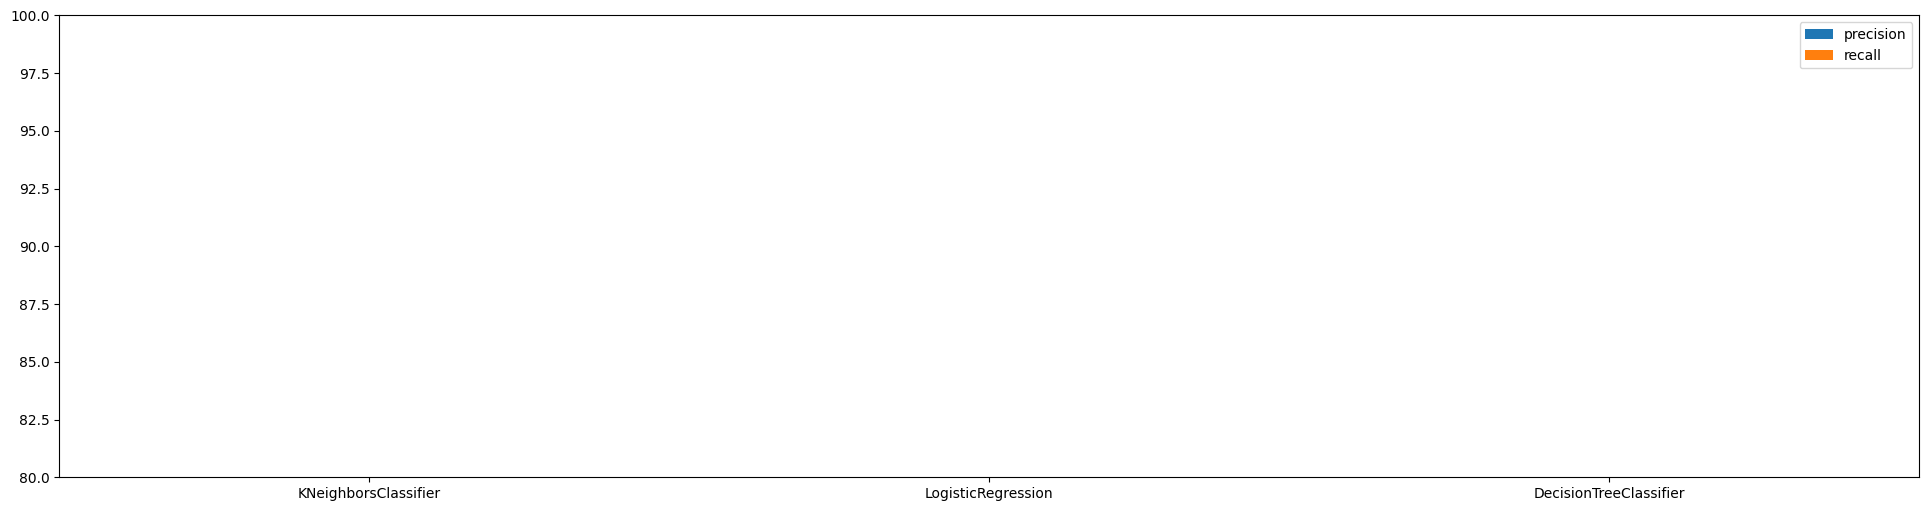

In [51]:
for name in models:
    for scorer in ['precision','recall']:
        scores[name][scorer] = scores[name][scorer].mean()
scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
scores.plot(kind = "bar", ylim=[80,100], figsize=(24,6), rot=0)

In [52]:
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc

In [53]:
preds={}
for name in models:
    models[name].fit(x_train, y_train)
    preds[name] = models[name].predict(x_test)
print("Прогнозы завершены.")

Прогнозы завершены.


In [54]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
target_names=["нормальный","аномальный"]
for name in models:
    print(line(name), name, 'Тестирование модели', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test, preds[name], target_names=target_names))

*************** KNeighborsClassifier Тестирование модели ***************
[[79 74]
 [75 72]]
---------------
              precision    recall  f1-score   support

  нормальный       0.51      0.52      0.51       153
  аномальный       0.49      0.49      0.49       147

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.50      0.50      0.50       300

**************** LogisticRegression Тестирование модели ****************
[[83 70]
 [75 72]]
----------------
              precision    recall  f1-score   support

  нормальный       0.53      0.54      0.53       153
  аномальный       0.51      0.49      0.50       147

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300

************** DecisionTreeClassifier Тестирование модели **************
[[88 65]
 [73 74]]
--------------
              precisio

<Axes: >

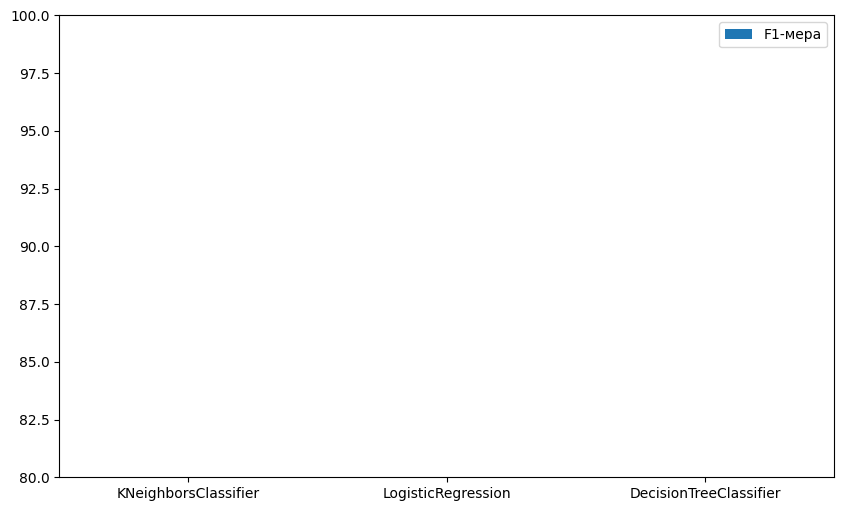

In [55]:
f1s = {}
for name in models:
    f1s[name]=f1_score(y_test, preds[name])
f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-мера"])*100
f1s.plot(kind = "bar", ylim=[80,100], figsize=(10,6), rot=0)